# Урок 6. Metric learning. 

## Задание
Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [20]:
# %tensorflow_version 2.x

https://tensorflow.google.cn/tutorials/load_data/images?hl=en

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import tarfile
import pathlib
import tensorflow as tf

In [23]:
# Можно еще вот так распаковать архив.
if 1:
    dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

    data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                    fname='lfw',
                                    untar=True )

    data_dir = pathlib.Path(data_dir)
else: 
    data_dir = pathlib.Path('lfw')

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


In [25]:
batch_size = 32
img_height = 180
img_width = 180

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names[:10])

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban']


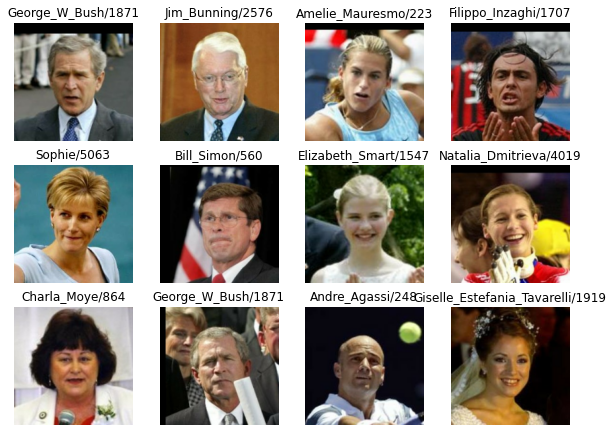

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'{class_names[labels[i]]}/{labels[i]}')
    plt.axis("off")

## Создание модели CNN

In [32]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [33]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    try:
        bs = embs.shape[0]
        embs1 = embs[:bs//2, :]
        embs2 = embs[bs//2:, :]
        labels1 = labels[:bs//2]
        labels2 = labels[bs//2:]

        d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
        d =  tf.sqrt(d2)
        z = tf.cast(labels1 == labels2, tf.float32)
    except Exception as ex:
        print('>',embs1)
        print('>',embs2)
        print(ex)
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка к обучению

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 3

In [35]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [37]:
%%time
for epoch in range(NUM_EPOCHS):
    for iteration, (images, labels) in enumerate(train_ds):
        if(len(labels)%2 > 0): # на последней операции в эпохе возникает ошибка.  из-за того что к-во элементов в батче не четное. 
                labels = labels[:-1]
                images = images[:-1]
        # Forward
        with tf.GradientTape() as tape:
            embs = model(images)
            loss_value = contastive_loss(embs, labels)
            
        # Backward
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if iteration % 100 == 0:
            print('[{}/{}] Loss: {}'.format(epoch,iteration, loss_value.numpy()))

2021-10-05 17:22:56.812711: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-05 17:23:04.582668: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8204
2021-10-05 17:23:14.643656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-05 17:23:21.859844: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


[0] Loss: 91.42977905273438
[100] Loss: 0.08470702171325684
[200] Loss: 0.049669813364744186
[300] Loss: 0.0
[0] Loss: 0.0
[100] Loss: 0.0
[200] Loss: 0.0
[300] Loss: 1.7231460809707642
[0] Loss: 0.0
[100] Loss: 1.1116443872451782
[200] Loss: 0.005774039309471846
[300] Loss: 0.0
[0] Loss: 0.0
[100] Loss: 0.0
[200] Loss: 0.06420447677373886
[300] Loss: 0.0004397853626869619
CPU times: user 3min 40s, sys: 10.2 s, total: 3min 50s
Wall time: 4min 39s


## Получение эмбеддингов для тестовой выборки

In [93]:
images, labels = next(iter(val_ds))

In [56]:
%%time

test_imgs=[]
test_labels = []
for iteration, (images, labels) in enumerate(val_ds):
    for label in labels.numpy():
        test_labels.append(label) 
    embs = model(images)
    for emb in embs.numpy():
        test_embs.append(emb)
test_labels = np.array(test_labels)
test_embs = np.array(test_embs)


CPU times: user 9.88 s, sys: 415 ms, total: 10.3 s
Wall time: 6.12 s


In [104]:
test_lbl_count = {}
for i in test_labels:
    name = class_names[i]
    if name in test_lbl_count:
        test_lbl_count[name] += 1
    else:
        test_lbl_count[name] = 1

In [106]:
test_lbl_count = list(test_lbl_count.items())
test_lbl_count = sorted(test_lbl_count, key=lambda x:x[1], reverse=True)
top_10 = test_lbl_count[:10]
top_10

[('George_W_Bush', 121),
 ('Colin_Powell', 50),
 ('Tony_Blair', 32),
 ('Donald_Rumsfeld', 29),
 ('Gerhard_Schroeder', 23),
 ('Junichiro_Koizumi', 19),
 ('Hugo_Chavez', 14),
 ('Jean_Chretien', 13),
 ('Serena_Williams', 12),
 ('Lleyton_Hewitt', 12)]

## Тестирование на новых данных

In [66]:
images, labels = next(iter(val_ds))

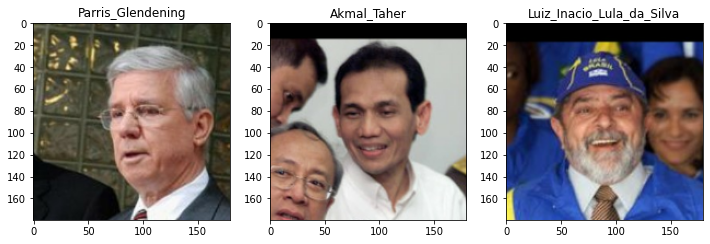

In [87]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    ax[i].imshow(images[i].numpy().astype("uint8"))
    ax[i].set_title(class_names[labels[i].numpy()])
plt.show()

## Получение эмбеддингов для новых данных

In [88]:
new_embs = model(np.stack(images[:3], axis=0))

## Вычисление расстояний между эмбеддингами

In [89]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  14.94516701036738
A2 <-> B1:  9.872779693157794
A1 <-> B1:  11.616803961389024
